In [1]:
import os
import sys
sys.path.append("./..")
from utils import PROJECT_ROOT, process_Danenberg_clinical_data
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import networkx as nx
from matplotlib.lines import Line2D
import pandas as pd
from c_Population_graph.population_graph import construct_PopulationGraph
from d_Patient_subgroups.community_detection import detect_communities
from e_Survival_analysis.survival_analysis import calculate_hazard_ratio
from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.statistics import multivariate_logrank_test, logrank_test


### Parameters

In [2]:
iteration = 2
PhenoGraph_k =  100
node_label = 'CellType'
size_smallest_cluster  = 10
survival_type = 'Disease-specific'
PopulationGraph_type = 'two_step_knn_graph'
para_dict = {
    'weight_threshold_percentile': 95,
    'knn_k': 30
}
knn_k = 3
patient_filtering_dict = {}

# Discovery

### Load Gram matrix and clinical data

In [3]:
SoftWL_dict= pickle.load(
    open(
        os.path.join(
            PROJECT_ROOT,
            "Output",
            "b_Soft_WL_Kernel_random_split",
            "Danenberg",
            "Subset_1",
            "SoftWL_dict_iter_"
            + str(iteration)
            + "_PhenoGraph_k_"
            + str(PhenoGraph_k)
            + "_"
            + node_label
            + ".pkl",
        ),
        "rb",
    ),
)
Patient_IDs = SoftWL_dict["Patient_id"]
Gram_matrix = SoftWL_dict["Gram_matrix"]
Histograms = SoftWL_dict["Histogram"]
Histograms = Histograms/np.sum(Histograms, axis=1, keepdims=True)

clinical = pd.read_csv(
    os.path.join(
        PROJECT_ROOT,
        "Input",
        "Clinical",
        "Danenberg",
        "clinical.csv",
    )
)
clinical = process_Danenberg_clinical_data(clinical)
Patient_Inclusion_mask = np.ones(len(Patient_IDs), dtype=bool)
for feature, included_values in patient_filtering_dict.items():
    Feature = [clinical.loc[clinical['patient_id'] == patient_id, feature].values[0] for patient_id in Patient_IDs]
    patient_inclusion_mask = np.array([feature  == included_values for feature in Feature])
    Patient_Inclusion_mask = Patient_Inclusion_mask * patient_inclusion_mask
Patient_IDs = np.array(Patient_IDs)[Patient_Inclusion_mask]
Gram_matrix = Gram_matrix[Patient_Inclusion_mask, :][:, Patient_Inclusion_mask]
Histograms = Histograms[Patient_Inclusion_mask, :]
print("{} patients are included".format(len(Patient_IDs)))

379 patients are included


### Community detection

In [4]:

# Histograms = Histograms[Indices, :]
print(Gram_matrix.shape)
# Gram_matrix[Gram_matrix<0.75] = 0
G_population = construct_PopulationGraph(
    Gram_matrix,
    PopulationGraph_type,
    para_dict = para_dict,
)

Community_ids = detect_communities(G_population, size_smallest_cluster, resolution = 1)
# KNN smoothing
# k = 5
# Gram_matrix_ = Gram_matrix.copy()
# np.fill_diagonal(Gram_matrix_, 1)
# for i in range(len(Community_ids)):
#     knn_community = Community_ids[np.argsort(Gram_matrix_[i,:])[::-1][:k]]
#     print(knn_community)
#     unqiue, counts = np.unique(knn_community, return_counts=True)
#     # print(unqiue[np.argmax(counts)])
#     Community_ids[i] = unqiue[np.argmax(counts)]

(379, 379)


In [5]:
def caculate_mutual_similarity(gram_matrix):
    gram_matrix_ = gram_matrix.copy()
    np.fill_diagonal(gram_matrix_, -1)
    return np.mean(gram_matrix_[gram_matrix_!=-1])
for i in range(1, int(np.max(Community_ids)+1)):
    Gram_matrix_ = Gram_matrix[Community_ids == i, :][:, Community_ids == i]
    # if caculate_mutual_similarity(Gram_matrix_) < 2* caculate_mutual_similarity(Gram_matrix):
    #     Community_ids[Community_ids == i] = 0
    print("{} subgroup {} patients, averaged Intra-group similarity is {:.2f} ".format(Gram_matrix_.shape[0], i, caculate_mutual_similarity(Gram_matrix_)))

print("Overall {} patients, averaged Intra-group similarity is {:.2f} ".format(Gram_matrix.shape[0], caculate_mutual_similarity(Gram_matrix)))



97 subgroup 1 patients, averaged Intra-group similarity is 0.37 
73 subgroup 2 patients, averaged Intra-group similarity is 0.45 
61 subgroup 3 patients, averaged Intra-group similarity is 0.32 
51 subgroup 4 patients, averaged Intra-group similarity is 0.61 
48 subgroup 5 patients, averaged Intra-group similarity is 0.26 
26 subgroup 6 patients, averaged Intra-group similarity is 0.75 
23 subgroup 7 patients, averaged Intra-group similarity is 0.73 
Overall 379 patients, averaged Intra-group similarity is 0.18 


### Survival analysis for subgroups

In [6]:
Length = [clinical.loc[clinical['patient_id'] == i, survival_type+ ' Survival (Months)'].values[0] for i in Patient_IDs]
Status = [clinical.loc[clinical['patient_id'] == i,  survival_type+ ' Survival Status'].values[0] for i in Patient_IDs]  
DF = pd.DataFrame({"Length": Length, "Status": Status, "Community_ids": Community_ids}).dropna()
Length_ = np.array(DF["Length"])
Status_ = np.array(DF["Status"])
Community_ids_ = np.array(DF["Community_ids"])
Histograms_ = Histograms[DF.index.values, :]
Patient_IDs_ = np.array(Patient_IDs)[DF.index.values]
print("{} patients are included".format(len(Patient_IDs_)))
HR = calculate_hazard_ratio(Length_, Status_, Community_ids_)
HR = sorted(HR, key=lambda x: x["hr"], reverse=True)
Subgroup_ids_ = np.zeros_like(Community_ids_)
for i in range(len(HR)):
    Subgroup_ids_[Community_ids_ == HR[i]["community_id"]] = i + 1
    HR[i]["subgroup_id"] = i + 1
for i in range(len(HR)):
    print("S{} (N = {}):".format(HR[i]['subgroup_id'], np.sum(Subgroup_ids_ == HR[i]['subgroup_id'])))
    print("Survival: hr = {}, p = {}".format(HR[i]["hr"], HR[i]["p"]))
    if HR[i]["p"] < 0.05/len(HR):
        print("\tSignificant")

379 patients are included
S1 (N = 26):
Survival: hr = 2.428013562030345, p = 0.0009529780614233097
	Significant
S2 (N = 48):
Survival: hr = 1.6715184635587368, p = 0.02843447397812587
S3 (N = 23):
Survival: hr = 1.1993259620126575, p = 0.6188721644067485
S4 (N = 73):
Survival: hr = 1.1496241238841327, p = 0.5148989278165488
S5 (N = 61):
Survival: hr = 0.9672335783354061, p = 0.8872245985054152
S6 (N = 51):
Survival: hr = 0.6150989479810047, p = 0.12382629829932304
S7 (N = 97):
Survival: hr = 0.514502885809581, p = 0.005382388188832714
	Significant


### Plot population graph

[[Text(-0.8, 0, ''),
  Text(-0.6000000000000001, 0, ''),
  Text(-0.4, 0, ''),
  Text(-0.19999999999999996, 0, ''),
  Text(0.0, 0, ''),
  Text(0.19999999999999996, 0, ''),
  Text(0.40000000000000013, 0, ''),
  Text(0.6000000000000001, 0, ''),
  Text(0.8, 0, ''),
  Text(1.0, 0, '')],
 [Text(-1.0, 0, ''),
  Text(-0.8, 0, ''),
  Text(-0.6, 0, ''),
  Text(-0.3999999999999999, 0, ''),
  Text(-0.19999999999999996, 0, ''),
  Text(0.0, 0, ''),
  Text(0.20000000000000018, 0, ''),
  Text(0.40000000000000013, 0, ''),
  Text(0.6000000000000001, 0, ''),
  Text(0.8, 0, '')],
 [Text(-0.8, 0, ''),
  Text(-0.6000000000000001, 0, ''),
  Text(-0.4, 0, ''),
  Text(-0.19999999999999996, 0, ''),
  Text(0.0, 0, ''),
  Text(0.19999999999999996, 0, ''),
  Text(0.40000000000000013, 0, ''),
  Text(0.6000000000000001, 0, ''),
  Text(0.8, 0, '')]]

/cis/home/zwang/venv/cell-gnn/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/cis/home/zwang/venv/cell-gnn/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  func(*args, **kwargs)


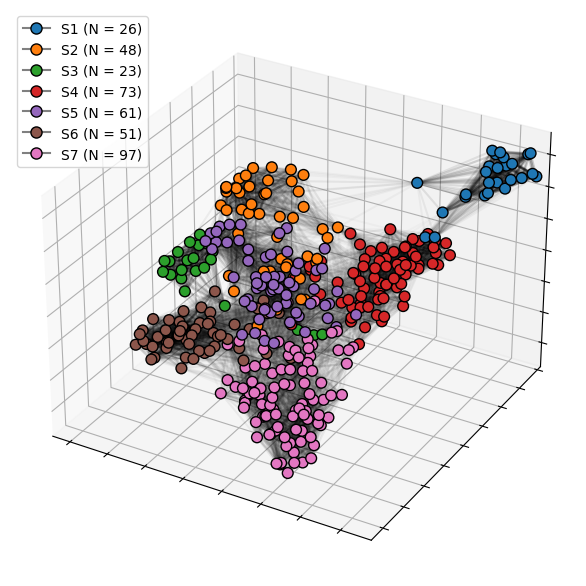

In [7]:
# from mayavi import mlab
G_population = construct_PopulationGraph(
    Gram_matrix,
    "two_step_knn_graph",
    para_dict={"weight_threshold_percentile": 90, "knn_k": 20},
)
color_palette = ["white"] + sns.color_palette("tab10") + sns.color_palette("Set2")
pos = nx.spring_layout(
    G_population, seed=3, k=1 / (np.sqrt(397)) * 10, iterations=100, dim=3
)
fig = plt.figure(figsize=(6,6), tight_layout=True)
ax = fig.add_subplot(111, projection="3d")
node_xyz = np.array([pos[v] for v in sorted(G_population)])
edge_xyz = np.array([(pos[u], pos[v]) for u, v in G_population.edges()])
ax.scatter(
    *node_xyz.T,
    s=60,
    c=[color_palette[int(i)] for i in Subgroup_ids_],
    # c= 'white',
    edgecolors="black",
    linewidths=1,
    alpha=1
)
edge_list = list(G_population.edges())
edge_alpha = [
    0.2*G_population[u][v]["weight"] if G_population[u][v]["weight"] > 0.1 else 0
    for u, v in edge_list
]
for i in range(len(edge_list)):
    u, v = edge_list[i]
    ax.plot(*edge_xyz[i].T, alpha=edge_alpha[i], color='k')

ax.set(
    xlim=(np.min(node_xyz[:, 0]), np.max(node_xyz[:, 0])),
    ylim=(np.min(node_xyz[:, 1]), np.max(node_xyz[:, 1])),
    zlim=(np.min(node_xyz[:, 2]), np.max(node_xyz[:, 2])),
)
handles = []
for i in range(1, len(HR)+1):
    handles.append(
    Line2D(
        [0],
        [0],
        marker="o",
        color='grey',
        markerfacecolor = color_palette[i],
        label="S{} (N = {})".format(i, np.sum(Subgroup_ids_ == i)),
        markeredgecolor="black",
        markeredgewidth=1,
        markersize=8,
    ))
   
ax.legend(handles=handles, fontsize = 10)

# ax.view_init(30, 0)
# ax.set_axis_off()
ax.set(yticklabels=[], xticklabels=[], zticklabels=[])
# ax.set(xlabel="x", ylabel="y", zlabel="z")


### Plot hazard ratio

/tmp/ipykernel_1110572/826111766.py:41: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax[0].set(ylim = (0,10))


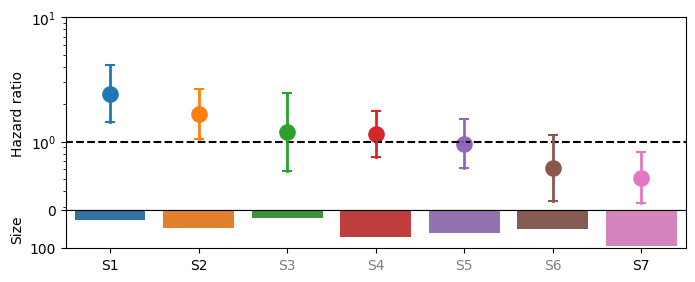

In [7]:
# Plot hazard ratio
num_significant = 0
color_palette = sns.color_palette("tab10") + sns.color_palette("Set2")
f, ax = plt.subplots(2, 1, height_ratios=[5, 1], figsize=(8, 3), sharex=True)
f.subplots_adjust(hspace=0)
ax[0].hlines(1, -1, len(HR), color="k", linestyle="--")
N, xticklabels, xtickcolors = [], [], []
for i in range(len(HR)):
    hr_dict = HR[i]
    subgroup_id = hr_dict['subgroup_id']
    hr, hr_lb, hr_ub, p = (
            hr_dict["hr"],
            hr_dict["hr_lower"],
            hr_dict["hr_upper"],
            hr_dict["p"],
        )
    ax[0].plot([i, i], [hr_lb, hr_ub], color=color_palette[i], linewidth=2)
    ax[0].scatter([i], [hr], color=color_palette[i], s=120)
    ax[0].scatter([i], [hr_lb], color=color_palette[i], s=60, marker="_")
    ax[0].scatter([i], [hr_ub], color=color_palette[i], s=60, marker="_")
    N.append(np.sum(Subgroup_ids_ == subgroup_id))
    xticklabels.append("S{}".format(int(subgroup_id)))
    if p < 0.05:
        xtickcolors.append("k")
        num_significant+=1
    else:
        xtickcolors.append("grey")
ax[0].set_xticks(range(len(HR)))
ax[0].set_xticklabels(xticklabels)
for xtick, color in zip(ax[1].get_xticklabels(), xtickcolors):
    xtick.set_color(color)
ax[0].set_xlabel("Patient Subgroups")
ax[0].set_ylabel("Hazard ratio")
ax[0].set_yscale("log")
# ax[1].set_title("Hazard ratios of Patient Subgroups")
DF = pd.DataFrame({"N": N, "subgroup_id": xticklabels})
g = sns.barplot(data=DF, x="subgroup_id", y="N", palette=color_palette, ax=ax[1])
g.invert_yaxis()
ax[1].set_ylabel("Size")
ax[1].set_xlabel("")
ax[0].set(ylim = (0,10))
plt.show()

### Plot K-M Plot

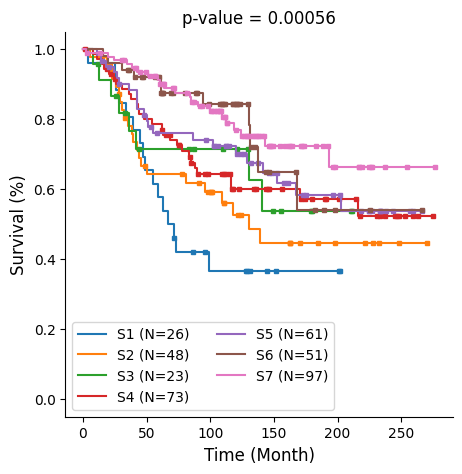

In [8]:
color_palette = sns.color_palette("tab10") + sns.color_palette("Set2")
kmf = KaplanMeierFitter()
f, ax = plt.subplots(figsize=(5, 5))
for i, hr_dict in enumerate(HR):
    subgroup_id = hr_dict['subgroup_id']
    length_A, event_observed_A = (
            Length_[Subgroup_ids_ == subgroup_id],
            Status_[Subgroup_ids_ == subgroup_id],
        )
    label = "S{} (N={})".format(hr_dict["subgroup_id"], np.sum(Subgroup_ids_ == subgroup_id))
    kmf.fit(length_A, event_observed_A, label=label)
    kmf.plot_survival_function(ax=ax, ci_show=False, color=color_palette[i],
    show_censors=True,
            censor_styles={"ms": 3, "marker": "s"})
log_rank_test  = multivariate_logrank_test(
        Length_[Subgroup_ids_!=0], Subgroup_ids_[Subgroup_ids_!=0],Status_[Subgroup_ids_!=0]
    )
p_value = log_rank_test.p_value
ax.legend(ncol=2, fontsize = 10)
ax.set_title("p-value = {:.5f}".format(p_value), fontsize = 12)
ax.set_xlabel("Time (Month)", fontsize = 12)
ax.set_ylabel("Survival (%)", fontsize = 12)
ax.set(
        ylim=(-0.05, 1.05),
    )
sns.despine()

# Validation

In [9]:
def map_subgroup(Reference_label,similarity_query_reference, k = 3):
    Label_query_hat = np.zeros((similarity_query_reference.shape[0]))
    # Reference_label = Subgroup_ids_
    # Reference_label = np.zeros_like(Subgroup_ids_)
    # Reference_label[Subgroup_ids_ == 1] = 1
    # Reference_label[Subgroup_ids_ == 2] = 2
    # Reference_label[Subgroup_ids_ == 7] = 7
    # knn_classifier

    for i in range(similarity_query_reference.shape[0]):
        knn_similarity = np.sort(similarity_query_reference[i, :])[::-1][:k]
        if k == -1:
            k = len(knn_similarity)
        knn_community = Reference_label[
                np.argsort(similarity_query_reference[i, :])[::-1][:k]
            ]
        unqiue, _ = np.unique(knn_community, return_counts=True)
        Similarity = np.zeros_like(unqiue)
        for j in range(len(unqiue)):
            Similarity[j] = np.sum(knn_similarity[knn_community == unqiue[j]])
            if k == -1:
                Similarity[j] = np.mean(knn_similarity[knn_community == unqiue[j]])
                # print(unqiue[j], Similarity[j])
        Label_query_hat[i] = unqiue[np.argmax(Similarity)]
    return Label_query_hat

## Subset 2

#### Load Gram matrix and clinical data

In [10]:
SoftWL_dict_cohort2 = pickle.load(
    open(
        os.path.join(
            PROJECT_ROOT,
            "Output",
            "b_Soft_WL_Kernel_random_split",
            "Danenberg",
            "Subset_2",
            "Matched_SoftWL_dict_iter_"
            + str(iteration)
            + "_PhenoGraph_k_"
            + str(PhenoGraph_k)
            + "_"
            + node_label
            + "_centroid_alignment.pkl",
        ),
        "rb",
    ),
)
Patient_IDs_cohort2 = SoftWL_dict_cohort2["Patient_id"]
Histograms_cohort2 = SoftWL_dict_cohort2["Histogram"]
Histograms_cohort2 = Histograms_cohort2/np.sum(Histograms_cohort2, axis=1, keepdims=True)

Patient_Inclusion_mask_cohort2 = np.ones(len(Patient_IDs_cohort2), dtype=bool)
for feature, included_values in patient_filtering_dict.items():
    Feature = [clinical.loc[clinical['patient_id'] == patient_id, feature].values[0] for patient_id in Patient_IDs_cohort2]
    patient_inclusion_mask_cohort2 = np.array([feature  == included_values for feature in Feature])
    Patient_Inclusion_mask_cohort2 = Patient_Inclusion_mask_cohort2 * patient_inclusion_mask_cohort2
Patient_IDs_cohort2 = np.array(Patient_IDs_cohort2)[Patient_Inclusion_mask_cohort2]
Histograms_cohort2 = Histograms_cohort2[Patient_Inclusion_mask_cohort2, :]
print("{} patients are included".format(len(Patient_IDs_cohort2)))

Length_cohort2 = [clinical.loc[clinical['patient_id'] == i, survival_type+' Survival (Months)'].values[0] for i in Patient_IDs_cohort2]
Status_cohort2 = [clinical.loc[clinical['patient_id'] == i, survival_type+' Survival Status'].values[0] for i in Patient_IDs_cohort2]  
DF_cohort2 = pd.DataFrame({"Length": Length_cohort2, "Status": Status_cohort2}).dropna()
Length_cohort2_ = np.array(DF_cohort2["Length"])
Status_cohort2_ = np.array(DF_cohort2["Status"])
Histograms_cohort2_ = Histograms_cohort2[DF_cohort2.index.values, :]
Patient_IDs_cohort2_ = np.array(Patient_IDs_cohort2)[DF_cohort2.index.values]

200 patients are included


#### Map subgroup ids

[{'community_id': True, 'hr': 1.8609328726498766, 'hr_lower': 0.8844999099053762, 'hr_upper': 3.915287178355282, 'p': 0.10172261679373597}]
[{'community_id': True, 'hr': 0.8218024702370736, 'hr_lower': 0.3745191585124478, 'hr_upper': 1.8032703661148206, 'p': 0.6245092767097735}]
[{'community_id': True, 'hr': 0.3805362286673194, 'hr_lower': 0.05273110401748185, 'hr_upper': 2.7461556898247093, 'p': 0.3379867511292472}]
[{'community_id': True, 'hr': 1.6501500566804215, 'hr_lower': 0.956675893267912, 'hr_upper': 2.84630900467337, 'p': 0.07174559509618547}]
[{'community_id': True, 'hr': 1.0241175736239991, 'hr_lower': 0.5055184427099785, 'hr_upper': 2.074734996774836, 'p': 0.9472510449649415}]
[{'community_id': True, 'hr': 0.8647373827409075, 'hr_lower': 0.34633810901581047, 'hr_upper': 2.1590772763486408, 'p': 0.7555744729642339}]
[{'community_id': True, 'hr': 0.6471548260195535, 'hr_lower': 0.3673528555346672, 'hr_upper': 1.1400738078674755, 'p': 0.13201037344331013}]
S1.0 (N = 19):
Survi

/tmp/ipykernel_1110572/3992294254.py:110: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax[0].set(ylim = (0, 10))


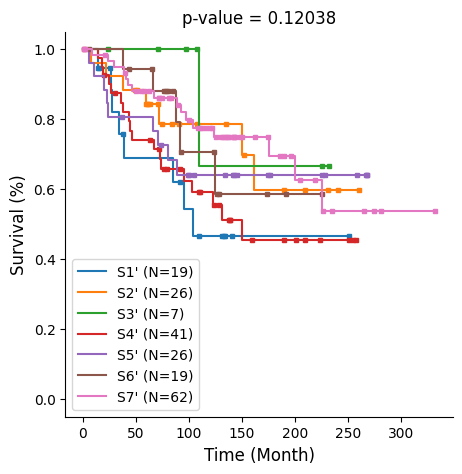

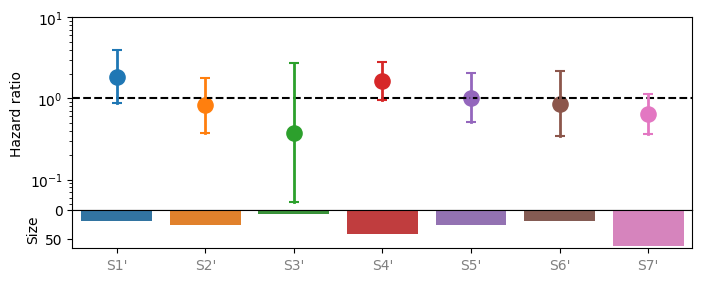

In [23]:
from b_Soft_WL_Kernel_random_split.SoftWL import get_Gram_matrix
from Alignment import centroid_alignment_based_on_similarity
color_palette = sns.color_palette("tab10") + sns.color_palette("Set2")
Gram_matrix_cohort2_ = get_Gram_matrix(Histograms_cohort2_)
Similarity_cohort2_discovery = get_Gram_matrix(
    np.concatenate([Histograms_cohort2_, Histograms_], axis=0)
)
Similarity_cohort2_discovery = Similarity_cohort2_discovery[
    : Histograms_cohort2_.shape[0], :
][:, Histograms_cohort2_.shape[0] :]

Label_query_hat = map_subgroup(Subgroup_ids_,Similarity_cohort2_discovery, k = 3)
kmf = KaplanMeierFitter()
f, ax = plt.subplots(figsize=(5, 5))
for subgroup_id in np.unique(Label_query_hat):
    subgroup_id = int(subgroup_id)
    length_A, event_observed_A = (
            Length_cohort2_[Label_query_hat == subgroup_id],
            Status_cohort2_[Label_query_hat == subgroup_id],
        )
    label = "S{}' (N={})".format(subgroup_id, np.sum(Label_query_hat == subgroup_id))
    kmf.fit(length_A, event_observed_A, label=label)
    kmf.plot_survival_function(
            ax=ax,
            ci_show=False,
            color=color_palette[subgroup_id - 1],
            show_censors=True,
            censor_styles={"ms": 3, "marker": "s"},
        )

group_label = np.zeros_like(Label_query_hat)
group_label[Label_query_hat == 1] = 1
group_label[Label_query_hat == 7] = 2
log_rank_test = multivariate_logrank_test(
        Length_cohort2_,
        group_label,
        Status_cohort2_,
    )
p_value = log_rank_test.p_value
ax.legend(ncol=1, fontsize=10)
ax.set_title("p-value = {:.5f}".format(p_value), fontsize=12)
ax.set_xlabel("Time (Month)", fontsize=12)
ax.set_ylabel("Survival (%)", fontsize=12)
ax.set(
        ylim=(-0.05, 1.05),
    )
sns.despine()


# Plot hazard ratio
num_significant = 0
HR = []
for i in np.unique(Label_query_hat):
    if i == 0:
        continue
    HR_ = calculate_hazard_ratio(Length_cohort2_, Status_cohort2_, Label_query_hat == i)
    print(HR_)
    HR.append({
            'subgroup_id': i ,
            'hr': HR_[0]['hr'],
            'hr_lower': HR_[0]['hr_lower'],
            'hr_upper': HR_[0]['hr_upper'],
            'p': HR_[0]['p']

        })

for i in range(len(HR)):
    print("S{} (N = {}):".format(HR[i]['subgroup_id'], np.sum(Label_query_hat == HR[i]['subgroup_id'])))
    print("Survival: hr = {}, p = {}".format(HR[i]["hr"], HR[i]["p"]))
    if HR[i]["p"] < 0.05:
        print("\tSignificant")
color_palette = sns.color_palette("tab10") + sns.color_palette("Set2")
f, ax = plt.subplots(2, 1, height_ratios=[5, 1], figsize=(8, 3), sharex=True)
f.subplots_adjust(hspace=0)
ax[0].hlines(1, -1, len(HR), color="k", linestyle="--")
N, xticklabels, xtickcolors = [], [], []
for i in range(len(HR)):
    hr_dict = HR[i]
    subgroup_id = int(hr_dict['subgroup_id'])
    hr, hr_lb, hr_ub, p = (
                hr_dict["hr"],
                hr_dict["hr_lower"],
                hr_dict["hr_upper"],
                hr_dict["p"],
            )
    ax[0].plot([i, i], [hr_lb, hr_ub], color=color_palette[subgroup_id-1], linewidth=2)
    ax[0].scatter([i], [hr], color=color_palette[subgroup_id-1], s=120)
    ax[0].scatter([i], [hr_lb], color=color_palette[subgroup_id-1], s=60, marker="_")
    ax[0].scatter([i], [hr_ub], color=color_palette[subgroup_id-1], s=60, marker="_")
    N.append(np.sum(np.sum(Label_query_hat ==subgroup_id)))
    xticklabels.append("S{}'".format(int(subgroup_id)))
    if p < 0.05:
        xtickcolors.append("k")
        num_significant+=1
    else:
        xtickcolors.append("grey")
ax[0].set_xticks(range(len(HR)))
ax[0].set_xticklabels(xticklabels)
for xtick, color in zip(ax[1].get_xticklabels(), xtickcolors):
    xtick.set_color(color)
ax[0].set_xlabel("Patient Subgroups")
ax[0].set_ylabel("Hazard ratio")
ax[0].set_yscale("log")
    # ax[1].set_title("Hazard ratios of Patient Subgroups")
DF = pd.DataFrame({"N": N, "subgroup_id": xticklabels})
g = sns.barplot(data=DF, x="subgroup_id", y="N", palette={"S{}'".format(int(subgroup_id)):color_palette[int(subgroup_id)-1] for subgroup_id in np.unique(Label_query_hat)}, ax=ax[1])
g.invert_yaxis()
ax[1].set_ylabel("Size")
ax[1].set_xlabel("")
ax[0].set(ylim = (0, 10))
plt.show()

# G_population = construct_PopulationGraph(
#         Gram_matrix_cohort2_,
#         'two_step_knn_graph',
#         para_dict = {
#             'weight_threshold_percentile': 90,
#             'knn_k':20
#         },
#     )
# color_palette = [sns.color_palette("tab10")[7]] + sns.color_palette("tab10") + sns.color_palette("Set2")

# pos = nx.spring_layout(
#         G_population, seed=100, k=1 / (np.sqrt(397)) * 10, iterations=100, dim=3
#     )


# fig = plt.figure(figsize=(6,6), tight_layout=True)
# ax = fig.add_subplot(111, projection="3d")
# node_xyz = np.array([pos[v] for v in sorted(G_population)])
# edge_xyz = np.array([(pos[u], pos[v]) for u, v in G_population.edges()])
# ax.scatter(
#         *node_xyz.T,
#         s=60,
#         c=[color_palette[int(i)] for i in Label_query_hat],
#         # # c= 'white',
#         edgecolors="black",
#         linewidths=1,
#         alpha=1
#     )
# edge_list = list(G_population.edges())
# edge_alpha = [
#         0.2*G_population[u][v]["weight"] if G_population[u][v]["weight"] > 0.1 else 0
#         for u, v in edge_list
#     ]
# for i in range(len(edge_list)):
#         u, v = edge_list[i]
#         ax.plot(*edge_xyz[i].T, alpha=edge_alpha[i], color='k')

# ax.set(
#         xlim=(np.min(node_xyz[:, 0]), np.max(node_xyz[:, 0])),
#         ylim=(np.min(node_xyz[:, 1]), np.max(node_xyz[:, 1])),
#         zlim=(np.min(node_xyz[:, 2]), np.max(node_xyz[:, 2])),
#     )

# handles = []
# for i in np.unique(Label_query_hat):
#     handles.append(
#     Line2D(
#             [0],
#             [0],
#             marker="o",
#             color='grey',
#             markerfacecolor=color_palette[int(i)],
#             label="S{}' (N = {})".format(int(i), np.sum(Label_query_hat == i)),
#             markeredgecolor="black",
#             markeredgewidth=1,
#             markersize=8,
#         ))
        
# ax.legend(handles=handles, fontsize = 10)
# ax.set(yticklabels=[], xticklabels=[], zticklabels=[])
# plt.show()

## Jackson

#### Load Gram matrix and clinical data

In [24]:
from utils import process_Jackson_clinical_data
survival_type_jackson = "Overall"
SoftWL_dict_jackson = pickle.load(
    open(
        os.path.join(
            PROJECT_ROOT,
            "Output",
            "b_Soft_WL_Kernel_random_split",
            "Jackson",
            "Matched_SoftWL_dict_iter_"
            + str(iteration)
            + "_PhenoGraph_k_"
            + str(PhenoGraph_k)
            + "_"
            + node_label
            + "_centroid_alignment.pkl",
        ),
        "rb",
    ),
)
Patient_IDs_jackson = SoftWL_dict_jackson["Patient_id"]
Histograms_jackson = SoftWL_dict_jackson["Histogram"]
Histograms_jackson = Histograms_jackson/np.sum(Histograms_jackson, axis=1, keepdims=True)
clinical = pd.read_csv(
    os.path.join(
        PROJECT_ROOT,
        "Input",
        "Clinical",
        "Jackson",
        "clinical.csv",
    )
)
clinical = process_Jackson_clinical_data(clinical)

Patient_Inclusion_mask_jackson = np.ones(len(Patient_IDs_jackson), dtype=bool)
for feature, included_values in patient_filtering_dict.items():
    Feature = [clinical.loc[clinical['patient_id'] == patient_id, feature].values[0] for patient_id in Patient_IDs_jackson]
    patient_inclusion_mask_jackson = np.array([feature  == included_values for feature in Feature])
    Patient_Inclusion_mask_jackson = Patient_Inclusion_mask_jackson * patient_inclusion_mask_jackson
Patient_IDs_jackson = np.array(Patient_IDs_jackson)[Patient_Inclusion_mask_jackson]
Histograms_jackson = Histograms_jackson[Patient_Inclusion_mask_jackson, :]

Length_jackson = [
        clinical.loc[clinical["patient_id"] == i, survival_type_jackson+" Survival (Months)"].values[0]
        for i in Patient_IDs_jackson
    ]
Status_jackson = [
        clinical.loc[clinical["patient_id"] == i, survival_type_jackson+" Survival Status"].values[0]
        for i in Patient_IDs_jackson
    ]

DF_jackson = pd.DataFrame({"Length": Length_jackson, "Status": Status_jackson}).dropna()
Length_jackson_ = np.array(DF_jackson["Length"])
Status_jackson_ = np.array(DF_jackson["Status"])
Histograms_jackson_ = Histograms_jackson[DF_jackson.index.values, :]
Patient_IDs_jackson_ = np.array(Patient_IDs_jackson)[DF_jackson.index.values]
print(len(Patient_IDs_jackson_))

266


#### Map subgroup ids

[{'community_id': True, 'hr': 2.8990795903137516, 'hr_lower': 1.5261171120082024, 'hr_upper': 5.507219861989582, 'p': 0.0011492780846801944}]
[{'community_id': True, 'hr': 1.673792445262462, 'hr_lower': 0.9859101936748378, 'hr_upper': 2.8416190113373334, 'p': 0.05646654519139466}]
[{'community_id': True, 'hr': 0.9061466793564799, 'hr_lower': 0.33085170136006764, 'hr_upper': 2.481782022378557, 'p': 0.8479626038243564}]
[{'community_id': True, 'hr': 0.7781899246115318, 'hr_lower': 0.43438659054309847, 'hr_upper': 1.3941027921920113, 'p': 0.39919985383159784}]
[{'community_id': True, 'hr': 1.0417251382411932, 'hr_lower': 0.5006591505634822, 'hr_upper': 2.167525076536145, 'p': 0.912927002924179}]
[{'community_id': True, 'hr': 0.6847858286751625, 'hr_lower': 0.21570059923588702, 'hr_upper': 2.1739931776522887, 'p': 0.5205973691912955}]
[{'community_id': True, 'hr': 0.5870824002156951, 'hr_lower': 0.3481097941574607, 'hr_upper': 0.9901064274196169, 'p': 0.045797995989619755}]
S1.0 (N = 17):


/tmp/ipykernel_1110572/465011029.py:110: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax[0].set(ylim = (0, 10))


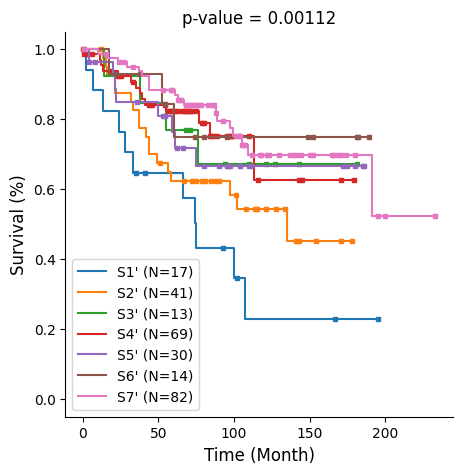

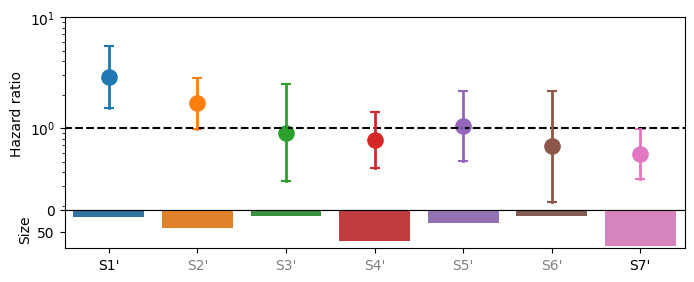

/cis/home/zwang/venv/cell-gnn/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
/cis/home/zwang/venv/cell-gnn/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


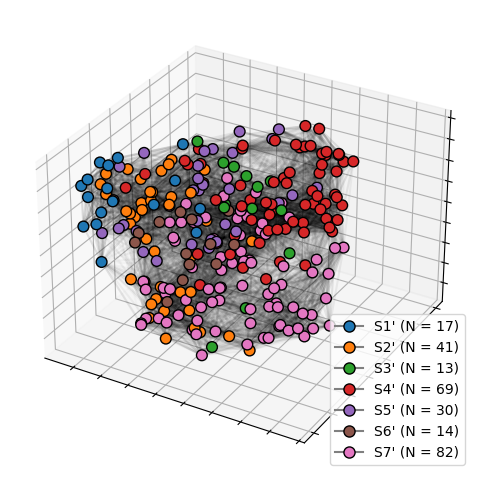

In [27]:
from b_Soft_WL_Kernel_random_split.SoftWL import get_Gram_matrix
from Alignment import centroid_alignment_based_on_similarity
color_palette = sns.color_palette("tab10") + sns.color_palette("Set2")
Gram_matrix_jackson_ = get_Gram_matrix(Histograms_jackson_)
Similarity_jackson_discovery = get_Gram_matrix(
    np.concatenate([Histograms_jackson_, Histograms_], axis=0)
)
Similarity_jackson_discovery = Similarity_jackson_discovery[
    : Histograms_jackson_.shape[0], :
][:, Histograms_jackson_.shape[0] :]

Label_query_hat = map_subgroup(Subgroup_ids_,Similarity_jackson_discovery, k = 3)
kmf = KaplanMeierFitter()
f, ax = plt.subplots(figsize=(5, 5))
for subgroup_id in np.unique(Label_query_hat):
    subgroup_id = int(subgroup_id)
    length_A, event_observed_A = (
            Length_jackson_[Label_query_hat == subgroup_id],
            Status_jackson_[Label_query_hat == subgroup_id],
        )
    label = "S{}' (N={})".format(subgroup_id, np.sum(Label_query_hat == subgroup_id))
    kmf.fit(length_A, event_observed_A, label=label)
    kmf.plot_survival_function(
            ax=ax,
            ci_show=False,
            color=color_palette[subgroup_id - 1],
            show_censors=True,
            censor_styles={"ms": 3, "marker": "s"},
        )

group_label = np.zeros_like(Label_query_hat)
group_label[Label_query_hat == 1] = 1
group_label[Label_query_hat == 7] = 2
log_rank_test = multivariate_logrank_test(
        Length_jackson_,
        group_label,
        Status_jackson_,
    )
p_value = log_rank_test.p_value
ax.legend(ncol=1, fontsize=10)
ax.set_title("p-value = {:.5f}".format(p_value), fontsize=12)
ax.set_xlabel("Time (Month)", fontsize=12)
ax.set_ylabel("Survival (%)", fontsize=12)
ax.set(
        ylim=(-0.05, 1.05),
    )
sns.despine()


# Plot hazard ratio
num_significant = 0
HR = []
for i in np.unique(Label_query_hat):
    if i == 0:
        continue
    HR_ = calculate_hazard_ratio(Length_jackson_, Status_jackson_, Label_query_hat == i)
    print(HR_)
    HR.append({
            'subgroup_id': i ,
            'hr': HR_[0]['hr'],
            'hr_lower': HR_[0]['hr_lower'],
            'hr_upper': HR_[0]['hr_upper'],
            'p': HR_[0]['p']

        })

for i in range(len(HR)):
    print("S{} (N = {}):".format(HR[i]['subgroup_id'], np.sum(Label_query_hat == HR[i]['subgroup_id'])))
    print("Survival: hr = {}, p = {}".format(HR[i]["hr"], HR[i]["p"]))
    if HR[i]["p"] < 0.05:
        print("\tSignificant")
color_palette = sns.color_palette("tab10") + sns.color_palette("Set2")
f, ax = plt.subplots(2, 1, height_ratios=[5, 1], figsize=(8, 3), sharex=True)
f.subplots_adjust(hspace=0)
ax[0].hlines(1, -1, len(HR), color="k", linestyle="--")
N, xticklabels, xtickcolors = [], [], []
for i in range(len(HR)):
    hr_dict = HR[i]
    subgroup_id = int(hr_dict['subgroup_id'])
    hr, hr_lb, hr_ub, p = (
                hr_dict["hr"],
                hr_dict["hr_lower"],
                hr_dict["hr_upper"],
                hr_dict["p"],
            )
    ax[0].plot([i, i], [hr_lb, hr_ub], color=color_palette[subgroup_id-1], linewidth=2)
    ax[0].scatter([i], [hr], color=color_palette[subgroup_id-1], s=120)
    ax[0].scatter([i], [hr_lb], color=color_palette[subgroup_id-1], s=60, marker="_")
    ax[0].scatter([i], [hr_ub], color=color_palette[subgroup_id-1], s=60, marker="_")
    N.append(np.sum(np.sum(Label_query_hat ==subgroup_id)))
    xticklabels.append("S{}'".format(int(subgroup_id)))
    if p < 0.05:
        xtickcolors.append("k")
        num_significant+=1
    else:
        xtickcolors.append("grey")
ax[0].set_xticks(range(len(HR)))
ax[0].set_xticklabels(xticklabels)
for xtick, color in zip(ax[1].get_xticklabels(), xtickcolors):
    xtick.set_color(color)
ax[0].set_xlabel("Patient Subgroups")
ax[0].set_ylabel("Hazard ratio")
ax[0].set_yscale("log")
    # ax[1].set_title("Hazard ratios of Patient Subgroups")
DF = pd.DataFrame({"N": N, "subgroup_id": xticklabels})
g = sns.barplot(data=DF, x="subgroup_id", y="N", palette={"S{}'".format(int(subgroup_id)):color_palette[int(subgroup_id)-1] for subgroup_id in np.unique(Label_query_hat)}, ax=ax[1])
g.invert_yaxis()
ax[1].set_ylabel("Size")
ax[1].set_xlabel("")
ax[0].set(ylim = (0, 10))
plt.show()

G_population = construct_PopulationGraph(
        Gram_matrix_jackson_,
        'two_step_knn_graph',
        para_dict = {
            'weight_threshold_percentile': 90,
            'knn_k':20
        },
    )
color_palette = [sns.color_palette("tab10")[7]] + sns.color_palette("tab10") + sns.color_palette("Set2")

pos = nx.spring_layout(
        G_population, seed=1, k=1 / (np.sqrt(200)) * 10, iterations=100, dim=3
    )


fig = plt.figure(figsize=(6,6), tight_layout=True)
ax = fig.add_subplot(111, projection="3d")
node_xyz = np.array([pos[v] for v in sorted(G_population)])
edge_xyz = np.array([(pos[u], pos[v]) for u, v in G_population.edges()])
ax.scatter(
        *node_xyz.T,
        s=60,
        c=[color_palette[int(i)] for i in Label_query_hat],
        # # c= 'white',
        edgecolors="black",
        linewidths=1,
        alpha=1
    )
edge_list = list(G_population.edges())
edge_alpha = [
        0.2*G_population[u][v]["weight"] if G_population[u][v]["weight"] > 0.1 else 0
        for u, v in edge_list
    ]
for i in range(len(edge_list)):
        u, v = edge_list[i]
        ax.plot(*edge_xyz[i].T, alpha=edge_alpha[i], color='k')

ax.set(
        xlim=(np.min(node_xyz[:, 0]), np.max(node_xyz[:, 0])),
        ylim=(np.min(node_xyz[:, 1]), np.max(node_xyz[:, 1])),
        zlim=(np.min(node_xyz[:, 2]), np.max(node_xyz[:, 2])),
    )

handles = []
for i in np.unique(Label_query_hat):
    handles.append(
    Line2D(
            [0],
            [0],
            marker="o",
            color='grey',
            markerfacecolor=color_palette[int(i)],
            label="S{}' (N = {})".format(int(i), np.sum(Label_query_hat == i)),
            markeredgecolor="black",
            markeredgewidth=1,
            markersize=8,
        ))
        
ax.legend(handles=handles, fontsize = 10)
ax.set(yticklabels=[], xticklabels=[], zticklabels=[])
plt.show()